In [23]:
import nltk
import random
import os
import re
import numpy as np
import pandas as pd
from collections import Counter
from nltk.corpus import reuters, stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

In [5]:
# Download the stopwords and Reuters corpus if not already downloaded
data_dir = "../data/"
nltk.data.path.append(os.path.abspath(data_dir))
nltk.download('stopwords', download_dir=data_dir)
nltk.download('reuters', download_dir=data_dir)

# Preprocess documents
def preprocess(doc):
    stop_words = set(stopwords.words('english'))
    doc = doc.lower()
    doc = re.sub(r'[^a-z]+', ' ', doc)
    words = nltk.word_tokenize(doc)
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

# Load the Reuters corpus and preprocess
fileids = reuters.fileids()
documents = [preprocess(reuters.raw(fileid)) for fileid in fileids]

# Extract top 10 categories
categories = reuters.categories()
category_counts = Counter(category for fileid in fileids for category in reuters.categories(fileid))
top_categories = [category for category, _ in category_counts.most_common(10)]


[nltk_data] Downloading package stopwords to ../data/...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package reuters to ../data/...


In [6]:
# Create labels
labels = np.zeros((len(fileids), len(top_categories)))
for i, fileid in enumerate(fileids):
    file_categories = reuters.categories(fileid)
    for j, category in enumerate(top_categories):
        if category in file_categories:
            labels[i, j] = 1

# Create features (TF-IDF weights)
vectorizer = TfidfVectorizer()
features = vectorizer.fit_transform(documents)

In [10]:
print(labels.shape)
print(features.shape)

(10788, 10)
(10788, 29022)


In [11]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# Split labels and features into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)

# Initialize the logistic regression model with Lasso penalty
logreg = LogisticRegression(penalty='l1', solver='liblinear')

# Choose the penalty parameter by cross-validation
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(logreg, param_grid, scoring='accuracy', cv=5)

# Fit the model and predict for each column in the labels
predicted_labels = np.zeros(y_test.shape)
for i in tqdm(range(y_test.shape[1])):
    grid_search.fit(X_train, y_train[:, i])
    best_model = grid_search.best_estimator_
    predicted_labels[:, i] = best_model.predict(X_test)

# Compare classification accuracy for each column of labels
accuracies = [accuracy_score(y_test[:, i], predicted_labels[:, i]) for i in range(y_test.shape[1])]


100%|██████████| 10/10 [00:08<00:00,  1.23it/s]

Column 0 (Category: earn): Accuracy = 0.98
Column 1 (Category: acq): Accuracy = 0.98
Column 2 (Category: money-fx): Accuracy = 0.98
Column 3 (Category: grain): Accuracy = 0.99
Column 4 (Category: crude): Accuracy = 0.99
Column 5 (Category: trade): Accuracy = 0.98
Column 6 (Category: interest): Accuracy = 0.98
Column 7 (Category: ship): Accuracy = 0.99
Column 8 (Category: wheat): Accuracy = 1.00
Column 9 (Category: corn): Accuracy = 0.99


In [12]:
for i, accuracy in enumerate(accuracies):
    print(f"Column {i} (Category: {top_categories[i]}): Accuracy = {accuracy:.2f}")


Column 0 (Category: earn): Accuracy = 0.98
Column 1 (Category: acq): Accuracy = 0.98
Column 2 (Category: money-fx): Accuracy = 0.98
Column 3 (Category: grain): Accuracy = 0.99
Column 4 (Category: crude): Accuracy = 0.99
Column 5 (Category: trade): Accuracy = 0.98
Column 6 (Category: interest): Accuracy = 0.98
Column 7 (Category: ship): Accuracy = 0.99
Column 8 (Category: wheat): Accuracy = 1.00
Column 9 (Category: corn): Accuracy = 0.99


In [41]:
# Find the indices of misclassified documents
misclassified_indices = np.where(np.any(y_test != predicted_labels, axis=1))

# Randomly select 5 misclassified document indices
sample_indices = random.sample(list(misclassified_indices[0]), 1)

# Print the text, actual labels, and predicted labels for the selected misclassified documents
for index in sample_indices:
    print(f"Document text: {reuters.raw(reuters.fileids()[index])}\n")
    print(f"Actual label set: {y_test[index]}\n")
    print(f"Predicted label set: {predicted_labels[index]}\n")
   
    # Identify the names of the misclassified labels
    misclassified_label_names = [top_categories[i] for i, (actual, predicted) in enumerate(zip(y_test[index], predicted_labels[index])) if actual != predicted]
    print(f"Misclassified label names: {misclassified_label_names}\n")
    
    print("-" * 80)

Document text: ARCO &lt;ARC> SPIN-OFF SEEN AT 500 MLN DLRS
  Atlantic Richfield Co, considering a
  spin-off of a 20 pct interest in its chemical operations, could
  gain about 500 mln dlrs from the deal, industry analysts
  estimated.
      Yesterday ARCO's stock jumped as much as five points on
  rumors it was spinning off the chemical operations. Based on
  about 183 mln outstanding shares, the market in its frenzy was
  valuing the spin-off at about 900 mln dlrs, analysts said.
      Atlantic Richfield, aware of the rumors, issued a statement
  around mid-day that it was considering a sale of only 20 pct of
  the unit, leading investors to take profits.
      After the announcement, the company's stock retreated,
  closing at 93-7/8, up 1-3/8. Today it was off 1/4.
      "It was a smaller deal than expected and somewhat
  disappointing," said analyst George Baker at Smith Barney. He
  said rumors of the spin-off had been around "for a couple of
  days."
      Baker said the unit wa

In [43]:
# a TSNE visualization of the articles

from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

# Reduce dimensionality to 100 using TruncatedSVD
svd = TruncatedSVD(n_components=100, random_state=42)
reduced_features = svd.fit_transform(features)


In [46]:
# Run t-SNE on the reduced features
tsne = TSNE(n_components=2, perplexity=20, random_state=42)
tsne_features = tsne.fit_transform(reduced_features)



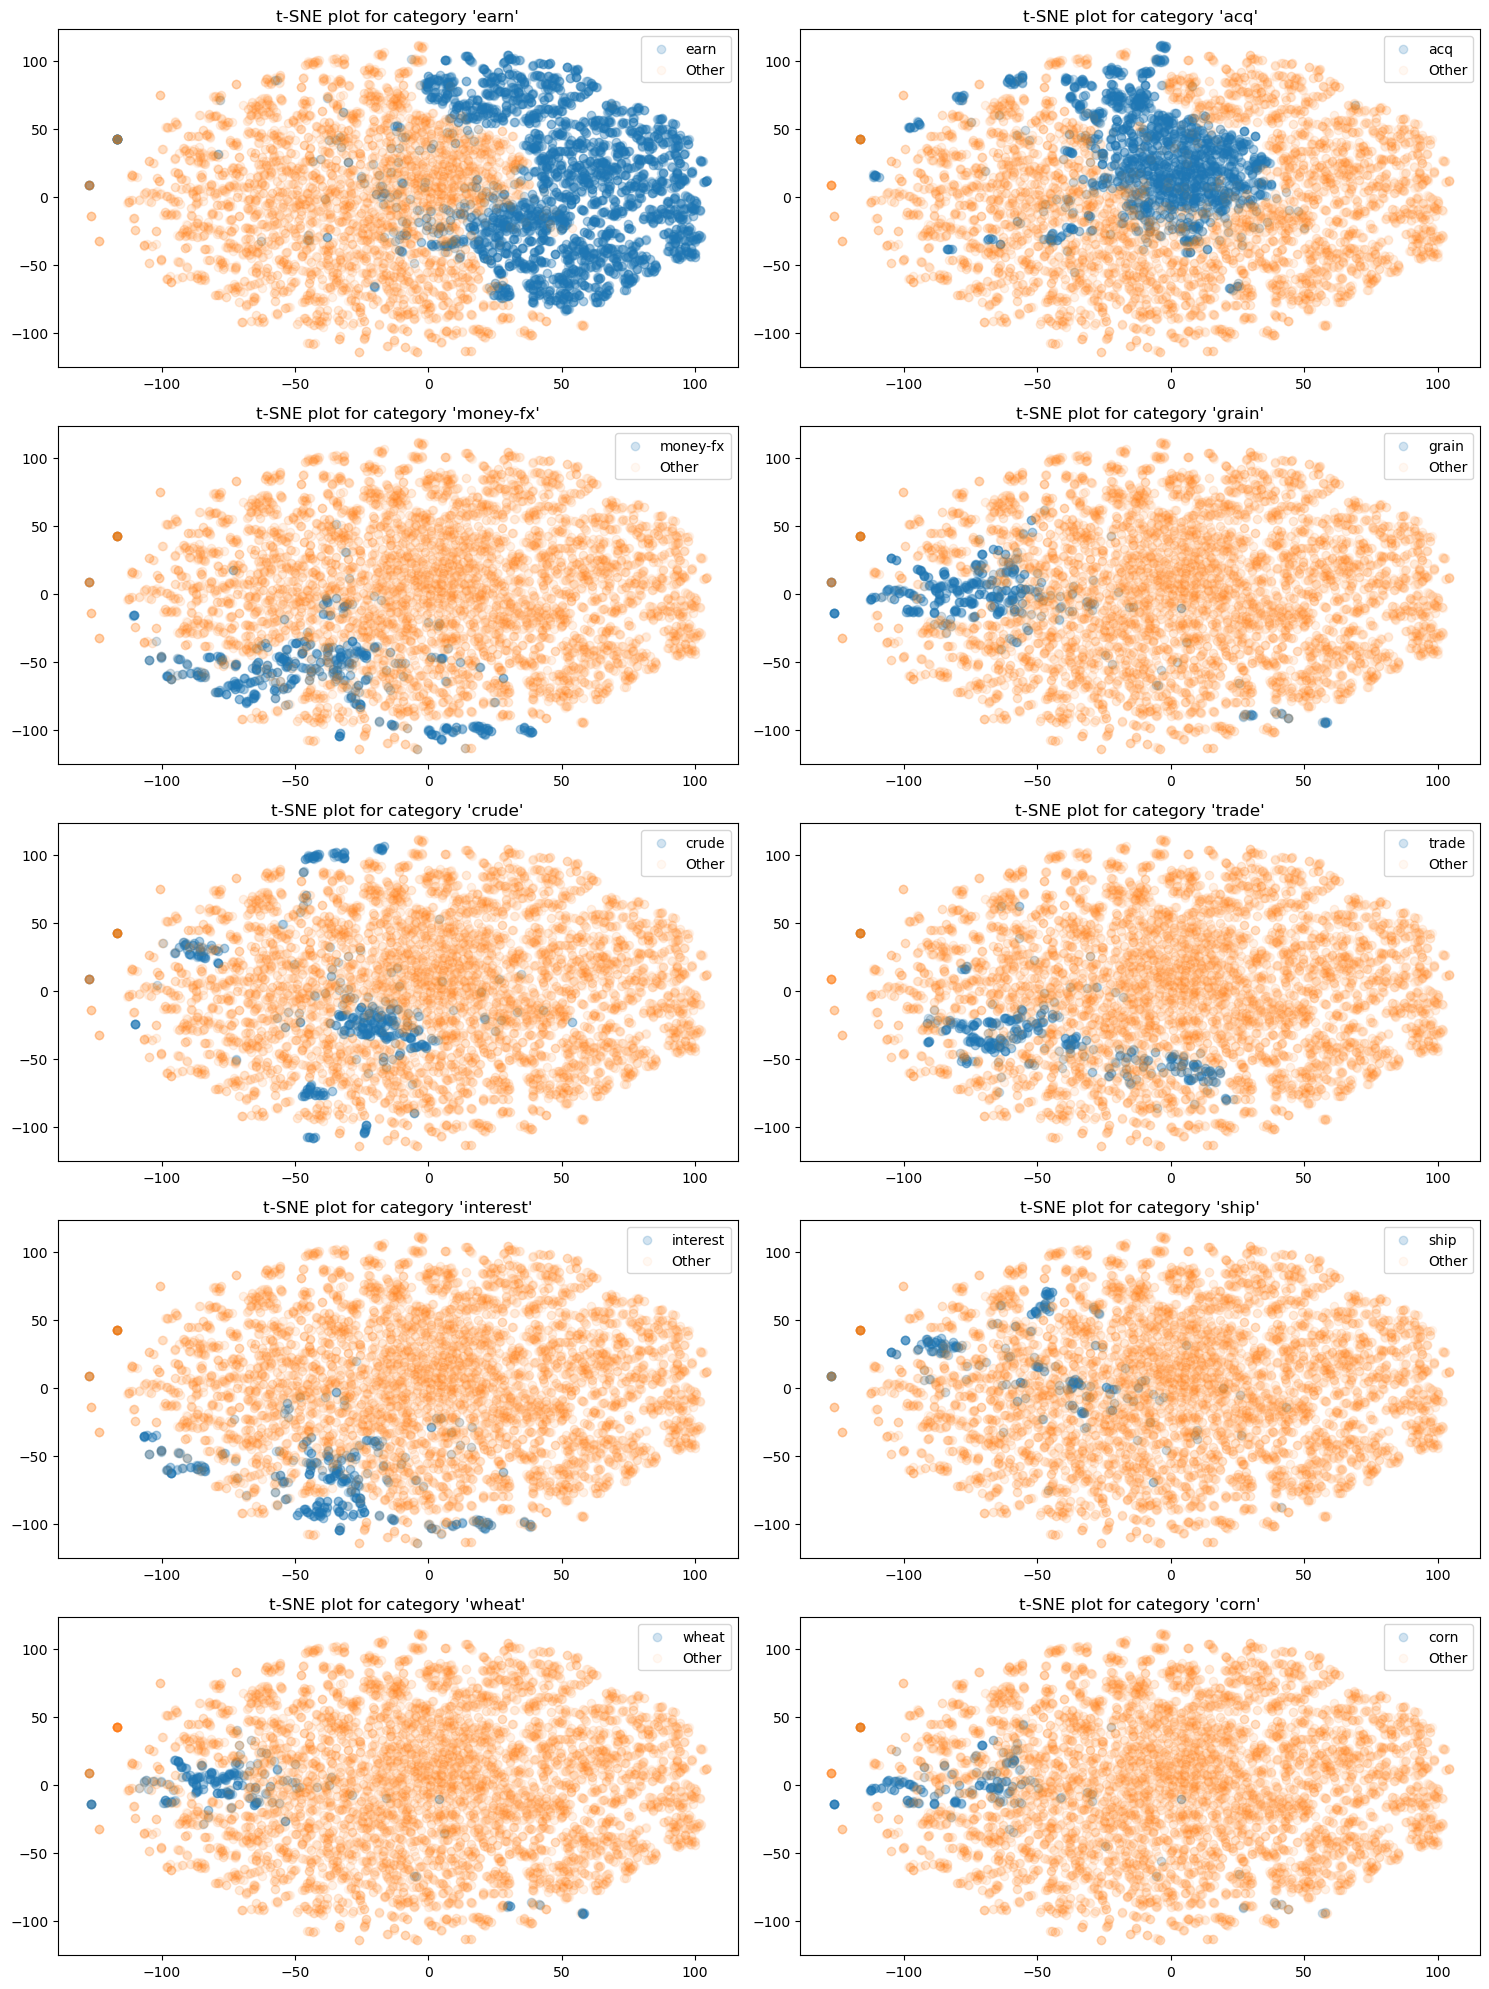

In [45]:
# Show 10 plots, one for each label, of the t-SNE features
fig, axes = plt.subplots(5, 2, figsize=(15, 20))
axes = axes.flatten()

for i, category in enumerate(top_categories):
    ax = axes[i]
    label_mask = (labels[:, i] == 1)
    
    ax.scatter(tsne_features[label_mask, 0], tsne_features[label_mask, 1], label=category, alpha=0.2)
    ax.scatter(tsne_features[~label_mask, 0], tsne_features[~label_mask, 1], label='Other', alpha=0.05)
    
    ax.set_title(f"t-SNE plot for category '{category}'")
    ax.legend()

plt.tight_layout()
plt.show()